In [1]:
import pickle
import os
import time
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from numpy import linalg as LA
import numpy as np
import math

with open("17_mnist.pkl", "br") as fh:
    data = pickle.load(fh)

train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]



In [2]:
for i in range(len(train_labels)):
    if train_labels[i]==7:
        train_labels[i]=np.array([0])
train_x = torch.FloatTensor(train_imgs)
train_y = torch.FloatTensor(train_labels)


for i in range(len(test_labels)):
    if test_labels[i]==7:
        test_labels[i]=np.array([0])
test_x = torch.FloatTensor(test_imgs)
test_y = torch.FloatTensor(test_labels)

In [3]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [4]:
device='cuda'

class LR(nn.Module):
    def __init__(self, input_size=784, num_class=1):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(input_size, num_class)

    def forward(self, x):
        x = self.fc1(x)
        return (x)

In [5]:
train_loader = torch.utils.data.DataLoader(LinearDataset(train_x, train_y), batch_size=len(train_imgs))
test_loader = torch.utils.data.DataLoader(LinearDataset(test_x, test_y), batch_size=len(test_imgs))

In [6]:
model = LR().to(device).double()

In [7]:
model.load_state_dict(torch.load("mnist17_gd_lr.pt"))

<All keys matched successfully>

In [8]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            criterion = nn.BCEWithLogitsLoss()
            data, target = data.to(device).double(), target.to(device)
            output = model(data.view(data.size(0), -1))
            test_loss += criterion(output, target).item()  # sum up batch loss
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred = torch.round(torch.sigmoid(output)) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:

test(model,device,test_loader)


Test set: Average loss: 0.0005, Accuracy: 1307/2163 (60.43%)



In [10]:
def autograd(outputs, inputs, create_graph=False):
    """Compute gradient of outputs w.r.t. inputs, assuming outputs is a scalar."""
    #inputs = tuple(inputs)
    grads = torch.autograd.grad(outputs, inputs, create_graph=create_graph, allow_unused=True)
    return [xx if xx is not None else yy.new_zeros(yy.size()) for xx, yy in zip(grads, inputs)]

from scipy.special import lambertw
import math
lambert_w = lambertw(1/math.e)



def tau(epoch,lr):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).double(), target.to(device).double()
        # initialize f function
        criterion = nn.BCEWithLogitsLoss()
        
        # calculate gradient of w on clean sample
        output_c = model(data.view(data.size(0), -1))

        loss_c = criterion(output_c,target)
        # wrt to w here
        grad_c= autograd(loss_c,tuple(model.parameters()),create_graph=True)
        g1 = grad_c[0]
        torch.save(g1.detach(), 'gmu_lr.pt')
        
        g1 = torch.flatten(g1)
        
        
        
        
        w_p = model.fc1.weight
        
        w_p = torch.flatten(w_p)
        g_mu_dot_w = np.dot(g1.cpu().detach().numpy().squeeze(),w_p.cpu().detach().numpy().squeeze())
        print(g_mu_dot_w)
        
        print('the necessary size of epsilon_d:{}'.format(g_mu_dot_w/lambert_w))
        break
            

        
        
print("==> start gradient canceling attack with given target parameters")
print("==> model will be saved in poisoned_models")
epochs=1
lr=1
for epoch in range(epochs):
    tau(epoch,lr)
    break
    

==> start gradient canceling attack with given target parameters
==> model will be saved in poisoned_models
0.711556503236389
the necessary size of epsilon_d:(2.555285840635422+0j)


In [21]:
optimizer = optim.Adadelta(model.parameters(), lr=0.1)
# define epsilon for one point for now



# load gmu to initialize the poisoned samples
gmu = torch.load('gmu_lr.pt')
print(gmu.size())

loss_epsilon=[] = []
def attack(epoch,lr,epsilon):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).double(), target.to(device).double()
        data.requires_grad=True
        if epoch==0:
            # initialize poisoned data with 1/epsilon g(mu)
            #data_p = Variable(data[:epsilon])
            data_p = Variable((gmu))
            target_p = Variable(torch.ones([1,1])).to(device).double()
            torch.save(target_p,'target_p_{}.pt'.format(epsilon))
        else:
            data_p = torch.load('data_p_{}.pt'.format(epsilon))
            target_p = torch.load('target_p_{}.pt'.format(epsilon))
        data_p.requires_grad=True
        # initialize f function with average
        criterion = nn.BCEWithLogitsLoss()
        
        # calculate gradient of w on clean sample
        output_c = model(data.view(data.size(0), -1))
        loss_c = criterion(output_c,target)
        # wrt to w here
        grad_c= autograd(loss_c,tuple(model.parameters()),create_graph=True)
        g1 = grad_c[0]
        
        
        # calculate gradient of w on poisoned sample
        output_p = model(data_p.view(data_p.size(0), -1))

        loss_p = criterion(output_p,target_p)
        grad_p= autograd(loss_p,tuple(model.parameters()),create_graph=True)
        g2 = grad_p[0]
        # calculate the true loss: |g_c + g_p|_{inf}
        
        grad_sum = g1+(epsilon*g2)

        
        loss = torch.norm(grad_sum,2).square()
        loss_epsilon.append(loss.detach().cpu().numpy())
            
        update = autograd(loss,data_p,create_graph=True)
        #print(update)
        
        data_t = data_p - lr * update[0]

        torch.save(data_t, 'data_p_{}.pt'.format(epsilon))
        
        
        print("epoch:{},loss:{},lr:{}".format(epoch, loss,lr))

        
        
print("==> start gradient canceling attack with given target parameters")
print("==> model will be saved in poisoned_models")
epochs=2000
lr= 0.1
#for epoch in range(epochs):
#    attack(epoch,lr)
    

torch.Size([1, 784])
==> start gradient canceling attack with given target parameters
==> model will be saved in poisoned_models


In [23]:
epsilon_all = [2.3,2.5,2.7,3]
loss_all=[]
epochs=2000
for epsilon in epsilon_all:
    print("==> start the attack for epsilon:{}".format(epsilon))
    loss_epsilon=[]
    for epoch in range(epochs):
        attack(epoch,lr,epsilon)
    loss_all.append(loss_epsilon)

==> start the attack for epsilon:2.3
epoch:0,loss:0.6121347532306077,lr:0.1
epoch:1,loss:0.0948339951838066,lr:0.1
epoch:2,loss:0.09176003061716524,lr:0.1
epoch:3,loss:0.08895469467399891,lr:0.1
epoch:4,loss:0.08634922917301395,lr:0.1
epoch:5,loss:0.08391696776817033,lr:0.1
epoch:6,loss:0.08163986734351214,lr:0.1
epoch:7,loss:0.07950316185163699,lr:0.1
epoch:8,loss:0.07749403148639822,lr:0.1
epoch:9,loss:0.07560121275464866,lr:0.1
epoch:10,loss:0.07381473653036548,lr:0.1
epoch:11,loss:0.07212574871217478,lr:0.1
epoch:12,loss:0.07052635531754425,lr:0.1
epoch:13,loss:0.06900949653051883,lr:0.1
epoch:14,loss:0.0675688387150469,lr:0.1
epoch:15,loss:0.06619868345771145,lr:0.1
epoch:16,loss:0.06489388965860166,lr:0.1
epoch:17,loss:0.06364980695279357,lr:0.1
epoch:18,loss:0.062462218395437225,lr:0.1
epoch:19,loss:0.061327291028489814,lr:0.1
epoch:20,loss:0.060241533052584874,lr:0.1
epoch:21,loss:0.059201756615791155,lr:0.1
epoch:22,loss:0.05820504536934929,lr:0.1
epoch:23,loss:0.0572487260969

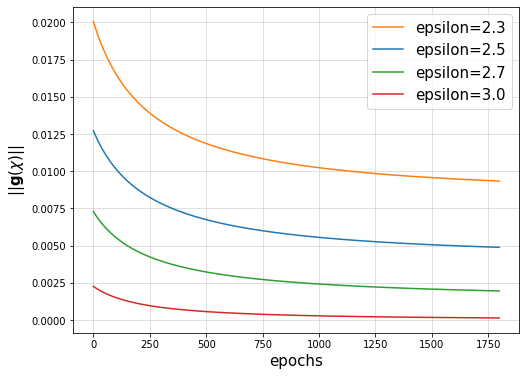

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
ax = plt.gca()
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(10)
#plt.plot([x for x in loss_all[0]])
plt.plot([x for x in loss_all[0][200:2000]], label='epsilon=2.3', color='C1',linewidth=1.5)
plt.plot([x for x in loss_all[1][200:2000]],label='epsilon=2.5', color='C0',linewidth=1.5)
plt.plot([x for x in loss_all[2][200:2000]], label='epsilon=2.7',color='C2',linewidth=1.5)
plt.plot([x for x in loss_all[3][200:2000]], label='epsilon=3.0',color='C3',linewidth=1.5)
#plt.savefig('poisoned_models/cnn/img/retrain_loss_{}.png'.format(epsilon))
ax.legend(fontsize=15)
plt.grid(color='lightgray', alpha=0.9, zorder=1)
plt.ylabel(r'$||\mathbf{g}(\chi)\||$',fontsize=15)
plt.xlabel('epochs',fontsize=15)
plt.savefig('scaling.png',dpi=700)
plt.show()